### <center> German Credit Risk Model 


Objective: Develop a machine learning model that can classify customers as good or bad credit risk.
- Dataset information:
https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,StandardScaler, RobustScaler, MinMaxScaler
from sklearn import model_selection,metrics,ensemble
from sklearn.model_selection import ShuffleSplit,train_test_split,RandomizedSearchCV, GridSearchCV,StratifiedKFold,RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report,precision_recall_curve,f1_score,auc,roc_curve,average_precision_score,confusion_matrix
import xgboost
from xgboost import XGBClassifier,plot_importance
import seaborn as sns

In [2]:
import os
os.environ['https_proxy'] = "set https_proxy=http://test-proxy:80"
os.environ['http_proxy'] = "set http_proxy=http://test-proxy:80"

Inp_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data",sep='\s+',header=None)

In [3]:
##Renaming variables as per german.doc##

Inp_data.columns=['Checking_Status','Duration_in_months','Credit_history','Loan_purpose','Credit_amount','Savings_status','Time_in_curr_emp',
                  'Inst_to_Income','Personal_status','guarantors','Time_at_curr_res','Property_Type','Age_in_years','Other_installments',
                  'Housing','Existing_credits_count','Employment','No_of_dependents','Phone','Foreign_worker','Target']
Inp_data.dtypes

Checking_Status           object
Duration_in_months         int64
Credit_history            object
Loan_purpose              object
Credit_amount              int64
Savings_status            object
Time_in_curr_emp          object
Inst_to_Income             int64
Personal_status           object
guarantors                object
Time_at_curr_res           int64
Property_Type             object
Age_in_years               int64
Other_installments        object
Housing                   object
Existing_credits_count     int64
Employment                object
No_of_dependents           int64
Phone                     object
Foreign_worker            object
Target                     int64
dtype: object

In [4]:
Num_Vars= ['Duration_in_months','Credit_amount','Inst_to_Income','Time_at_curr_res','Age_in_years','Existing_credits_count','No_of_dependents','Target']

Cat_Vars= ['Checking_Status','Credit_history','Loan_purpose','Savings_status','Time_in_curr_emp','Personal_status','guarantors','Property_Type','Other_installments','Housing','Employment','Phone','Foreign_worker']

" Key- 1:Good(No default), 2: Bad(Default)"
"Transforming labels"
Inp_data['Target']= Inp_data['Target']-1

In [5]:
##Data Sanitization##########

def missing(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing(Inp_data)

,Total,Percent
Checking_Status,0,0.0
Property_Type,0,0.0
Foreign_worker,0,0.0
Phone,0,0.0
No_of_dependents,0,0.0
Employment,0,0.0
Existing_credits_count,0,0.0
Housing,0,0.0
Other_installments,0,0.0
Age_in_years,0,0.0


In [6]:
## Event rate####
print('Event rate is', (Inp_data[Inp_data['Target']==1].shape[0]/Inp_data.shape[0])*100,'%')

Event rate is 30.0 %


In [7]:
Summary= Inp_data.describe(percentiles=[.005,.01,0.05,0.1,0.25,0.5,.75,.90,.950,.990,.995,.999])
Summary=Summary.transpose()
print(Summary)

                         count      mean          std    min     0.5%      1%  \
Duration_in_months      1000.0    20.903    12.058814    4.0    4.000    6.00   
Credit_amount           1000.0  3271.258  2822.736876  250.0  361.905  425.83   
Inst_to_Income          1000.0     2.973     1.118715    1.0    1.000    1.00   
Time_at_curr_res        1000.0     2.845     1.103718    1.0    1.000    1.00   
Age_in_years            1000.0    35.546    11.375469   19.0   20.000   20.00   
Existing_credits_count  1000.0     1.407     0.577654    1.0    1.000    1.00   
No_of_dependents        1000.0     1.155     0.362086    1.0    1.000    1.00   
Target                  1000.0     0.300     0.458487    0.0    0.000    0.00   

                            5%    10%     25%     50%      75%     90%  \
Duration_in_months        6.00    9.0    12.0    18.0    24.00    36.0   
Credit_amount           708.95  932.0  1365.5  2319.5  3972.25  7179.4   
Inst_to_Income            1.00    1.0     2.0   

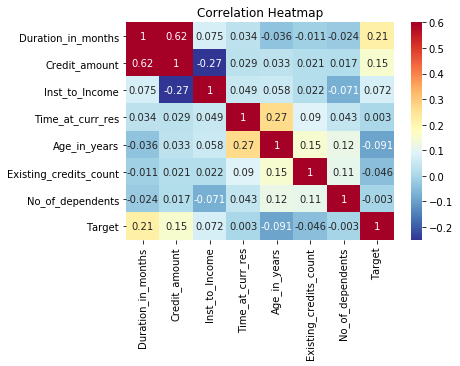

In [8]:
#####Correlation Heatmap#####

Inp_data_corrs= Inp_data[Num_Vars].corr()
sns.heatmap(Inp_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022E2E483888>,
      dtype=object)

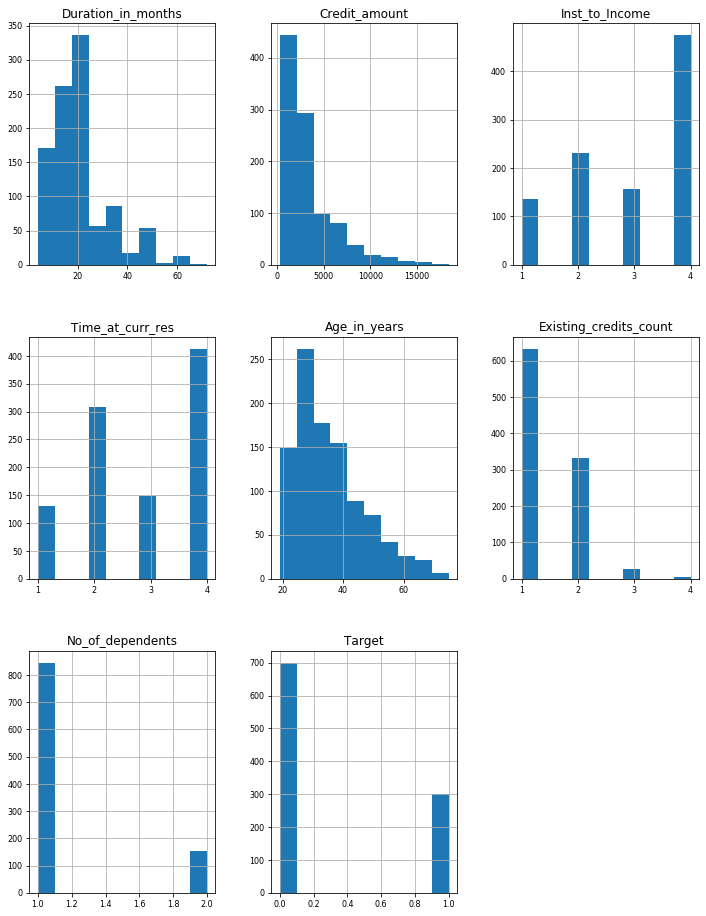

In [9]:
Inp_data.hist(figsize=(12, 16), bins=10, xlabelsize=8, ylabelsize=8)

<Figure size 432x288 with 0 Axes>

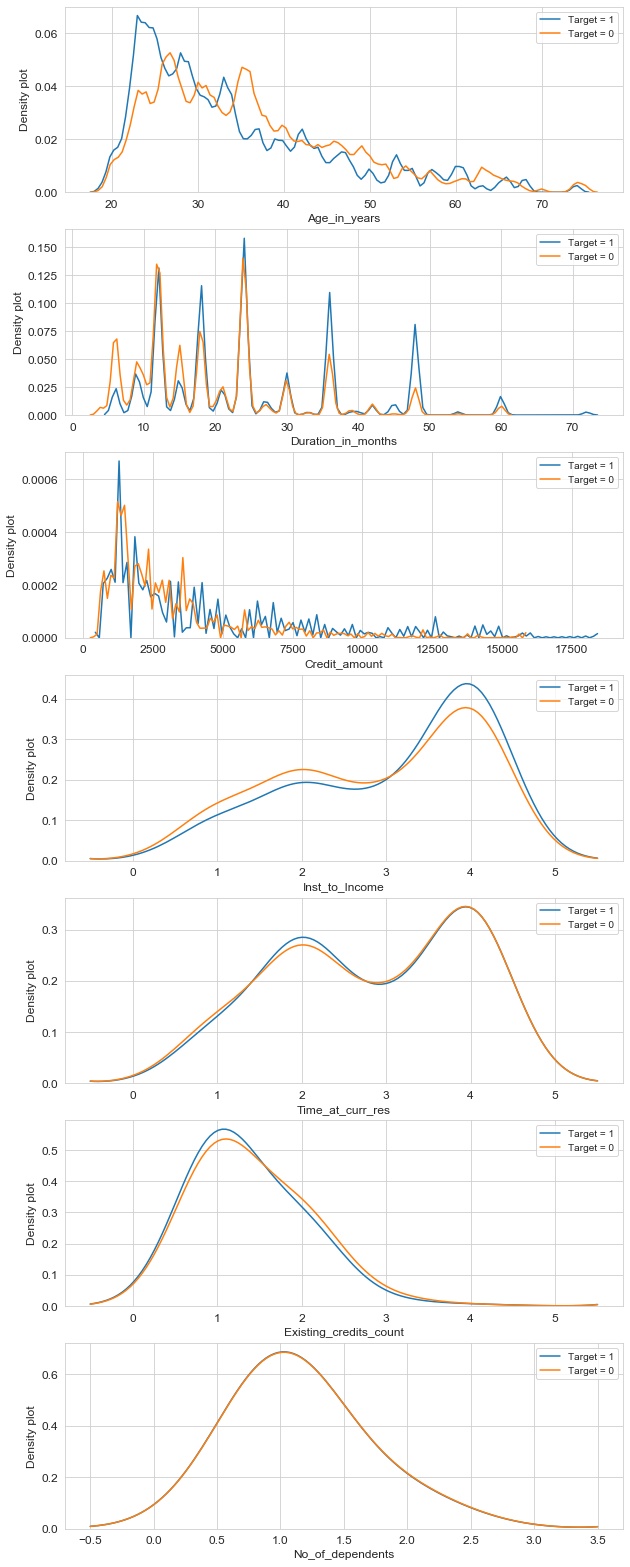

In [10]:
#Kernel Density Estimate

def plot_dist(var,nrow=7):    
    i = 0
    m1 = Inp_data.loc[Inp_data['Target'] != 0]
    m0 = Inp_data.loc[Inp_data['Target'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(10,4*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,1,i)
        sns.kdeplot(m1[feature],bw=0.5, label="Target = 1")
        sns.kdeplot(m0[feature],bw=0.5, label="Target = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();
       
var=['Age_in_years','Duration_in_months','Credit_amount','Inst_to_Income','Time_at_curr_res','Existing_credits_count','No_of_dependents']

plot_dist(var)

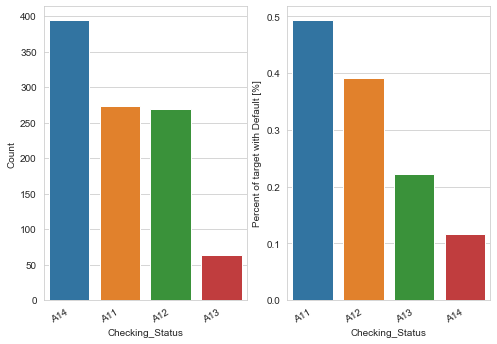

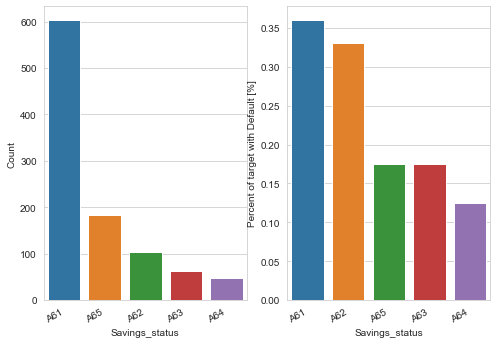

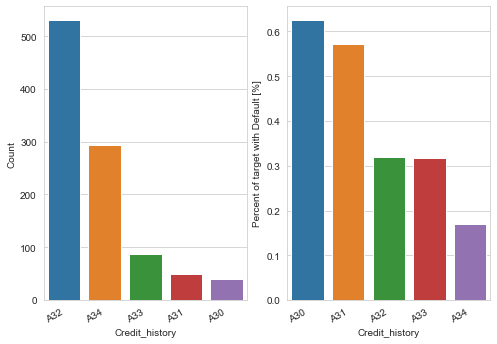

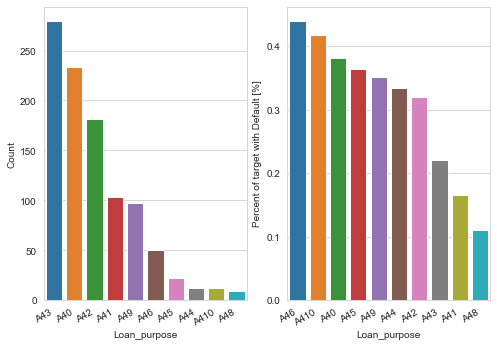

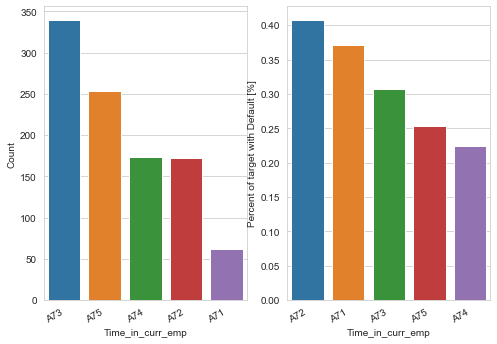

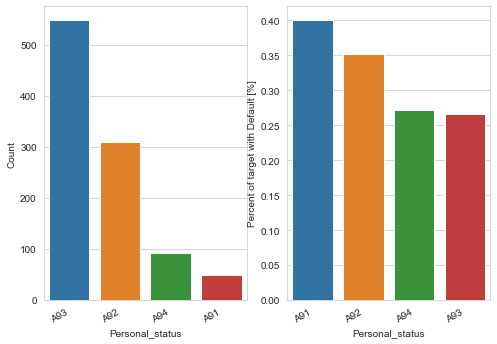

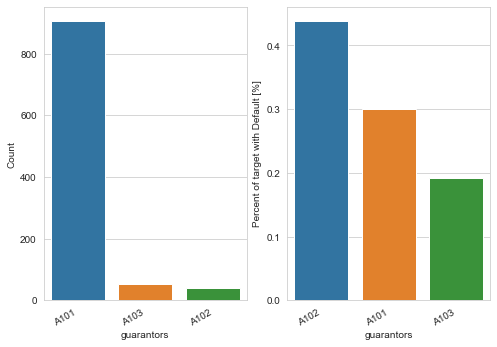

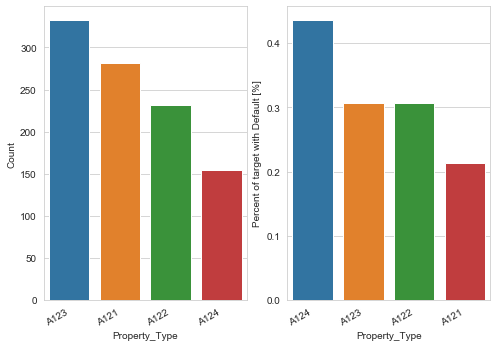

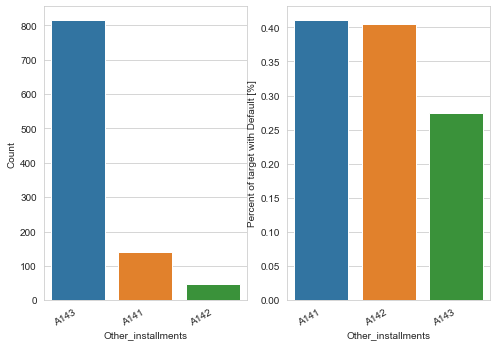

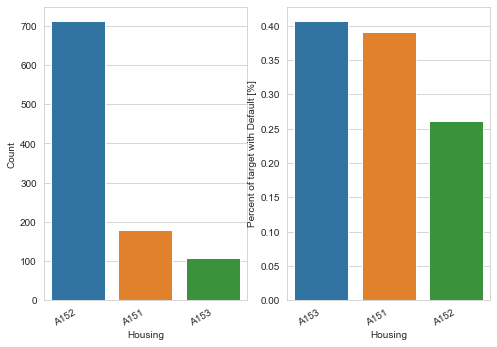

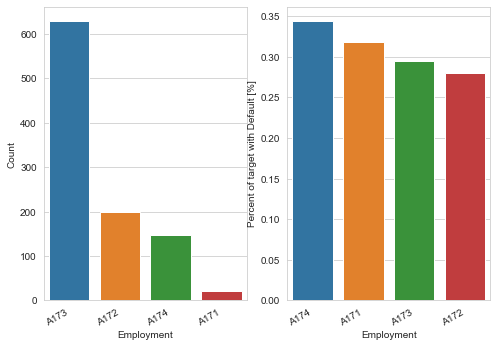

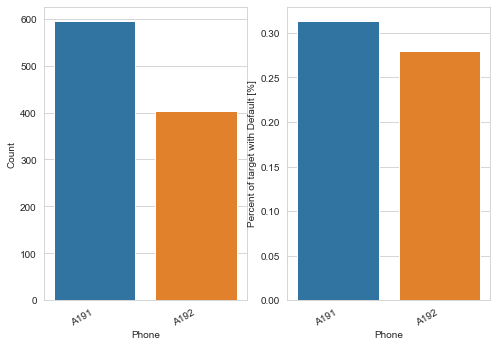

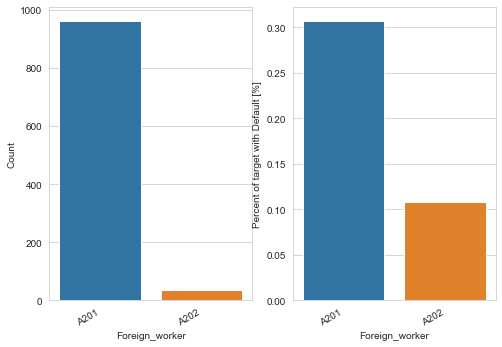

In [11]:
def Target_perc(feature,label_rotation=False,horizontal_layout=True):
    temp = Inp_data[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Count': temp.values})

    # Calculate the percentage of target=1 per category value
    level_perc = Inp_data[[feature, 'Target']].groupby([feature],as_index=False).mean()
    level_perc.sort_values(by='Target', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,12))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Count",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    fig.autofmt_xdate()
    s = sns.barplot(ax=ax2, x = feature, y='Target', order=level_perc[feature], data=level_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with Default [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.show();
        
Target_perc('Checking_Status')
Target_perc('Savings_status')
Target_perc('Credit_history')
Target_perc('Loan_purpose')
Target_perc('Time_in_curr_emp')
Target_perc('Personal_status')
Target_perc('guarantors')
Target_perc('Property_Type')
Target_perc('Other_installments')
Target_perc('Housing')
Target_perc('Employment')
Target_perc('Phone')
Target_perc('Foreign_worker')

In [12]:
##### Encoding for categorical features
    
# Labelencoding to transform categorical to numerical
    
d1 = defaultdict(LabelEncoder)

# Encoding the variable
Cat_data = Inp_data[Cat_Vars].apply(lambda x: d1[x.name].fit_transform(x))

# print transformations
for x in range(len(Cat_Vars)):
    print(Cat_Vars[x],": ", Inp_data[Cat_Vars[x]].unique())
    print(Cat_Vars[x],": ", Cat_data[Cat_Vars[x]].unique())

Checking_Status :  ['A11' 'A12' 'A14' 'A13']
Checking_Status :  [0 1 3 2]
Credit_history :  ['A34' 'A32' 'A33' 'A30' 'A31']
Credit_history :  [4 2 3 0 1]
Loan_purpose :  ['A43' 'A46' 'A42' 'A40' 'A41' 'A49' 'A44' 'A45' 'A410' 'A48']
Loan_purpose :  [4 7 3 0 1 9 5 6 2 8]
Savings_status :  ['A65' 'A61' 'A63' 'A64' 'A62']
Savings_status :  [4 0 2 3 1]
Time_in_curr_emp :  ['A75' 'A73' 'A74' 'A71' 'A72']
Time_in_curr_emp :  [4 2 3 0 1]
Personal_status :  ['A93' 'A92' 'A91' 'A94']
Personal_status :  [2 1 0 3]
guarantors :  ['A101' 'A103' 'A102']
guarantors :  [0 2 1]
Property_Type :  ['A121' 'A122' 'A124' 'A123']
Property_Type :  [0 1 3 2]
Other_installments :  ['A143' 'A141' 'A142']
Other_installments :  [2 0 1]
Housing :  ['A152' 'A153' 'A151']
Housing :  [1 2 0]
Employment :  ['A173' 'A172' 'A174' 'A171']
Employment :  [2 1 3 0]
Phone :  ['A192' 'A191']
Phone :  [1 0]
Foreign_worker :  ['A201' 'A202']
Foreign_worker :  [0 1]


In [13]:
#Create dummy variables for every category of every categorical variable

dummy = pd.get_dummies(Inp_data[Cat_Vars])
Inp_data_Trans= pd.concat([Inp_data[Num_Vars], dummy], axis = 1)
Inp_data_Num= pd.concat([Inp_data[Num_Vars], Cat_data], axis = 1)

In [14]:
Inp_data_Trans

,Duration_in_months,Credit_amount,Inst_to_Income,Time_at_curr_res,Age_in_years,Existing_credits_count,No_of_dependents,Target,Checking_Status_A11,Checking_Status_A12,...,Housing_A152,Housing_A153,Employment_A171,Employment_A172,Employment_A173,Employment_A174,Phone_A191,Phone_A192,Foreign_worker_A201,Foreign_worker_A202
0,6,1169,4,4,67,2,1,0,1,0,...,1,0,0,0,1,0,0,1,1,0
1,48,5951,2,2,22,1,1,1,0,1,...,1,0,0,0,1,0,1,0,1,0
2,12,2096,2,3,49,1,2,0,0,0,...,1,0,0,1,0,0,1,0,1,0
3,42,7882,2,4,45,1,2,0,1,0,...,0,1,0,0,1,0,1,0,1,0
4,24,4870,3,4,53,2,2,1,1,0,...,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1,0,0,0,...,1,0,0,1,0,0,1,0,1,0
996,30,3857,4,4,40,1,1,0,1,0,...,1,0,0,0,0,1,0,1,1,0
997,12,804,4,4,38,1,1,0,0,0,...,1,0,0,0,1,0,1,0,1,0
998,45,1845,4,4,23,1,1,1,1,0,...,0,1,0,0,1,0,0,1,1,0


In [15]:
def feature_scaling(df, type_scale):
    '''
    This function takes in customers dataframe and applies the selected feature scaler
    Args: customer  dataframe and a string representing the type of scaling intended
    returns: scaled dataframe
    '''
    
    features_list = df.columns
    
    if type_scale == 'StandardScaler':
        df_scaled = StandardScaler().fit_transform(df)
        
    if type_scale == 'MinMaxScaler':
        df_scaled = MinMaxScaler().fit_transform(df)
    
    df_scaled = pd.DataFrame(df_scaled)
    df_scaled.columns = features_list
    
    return df_scaled

In [16]:
Inp_data_scaled=feature_scaling(df= Inp_data_Trans,type_scale= 'MinMaxScaler')

In [17]:
Inp_data_scaled.shape

(1000, 62)

### <center> Principal Component Analysis

In [18]:
from sklearn.decomposition import PCA

In [19]:
def pca_model(df, n_components):
    '''
    This function defines a model that takes in a previously scaled dataframe and returns the result of 
    the transformation. The output is an onject created post data fitting
    '''
    pca = PCA(n_components)
    pca_df = pca.fit(df)
    
    return pca_df

In [20]:
n_components_seg= len(Inp_data_scaled.columns.values)
Seg_pca = pca_model(Inp_data_scaled,n_components_seg)

In [21]:
def PCA_plots(SS,dataname):
    '''
    This function takes in the transformed data using PCA
    '''
    plt.plot(np.cumsum(SS.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio vs Number of Components on ' + dataname)
    plt.grid(b=True)
    plot = plt.show()

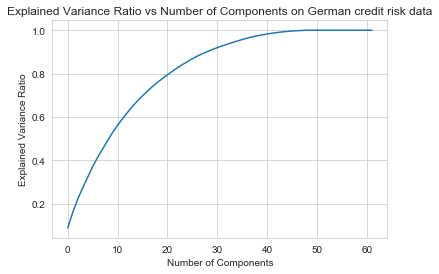

In [22]:
PCA_plots(Seg_pca, 'German credit risk data')

In [23]:
#function to display top features

def top_features(df, pca, dimensions):
    '''
    This function displays interesting features of the selected dimension
    '''
    
    features = df.columns.values
    components = pca.components_
    feature_weights = dict(zip(features, components[dimensions]))
    sorted_weights = sorted(feature_weights.items(), key = lambda kv: kv[1])
    
    print('Negative: ')
    for feature, weight, in sorted_weights[:3]:
        print('\t{:20} {:.3f}'.format(feature, weight))
    
    print('Positive: ')
    for feature, weight in sorted_weights[-3:]:
        print('\t{:20} {:.3f}'.format(feature, weight))

In [24]:
top_features(Inp_data_scaled, Seg_pca, 3)

Negative: 
	Housing_A152         -0.442
	Savings_status_A61   -0.233
	Checking_Status_A12  -0.212
Positive: 
	Time_at_curr_res     0.238
	Personal_status_A92  0.239
	Housing_A151         0.288


#### <center>  Cluster Analysis

In [25]:
from sklearn.cluster import KMeans

In [26]:
#function to fit the kmeans model
def fit_kmeans(data, centers):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset 
        center - the number of centers(the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data 
    '''
    kmeans = KMeans(centers)
    model = kmeans.fit(data)
    
    # SSE score for kmeans model 
    score = np.abs(model.score(data))
    return score

In [27]:
#function to display elbow plot
def elbow_method(data):
    scores = []
    centers = list(range(1,15))
    i = 0
    for center in centers:
        i += 1
        print(i)
        scores.append(fit_kmeans(data, center))
        
    # Investigate the change in within-cluster distance across number of clusters.
    # Plot the original data with clusters
    f = plt.figure()
    plt.plot(centers, scores, linestyle='--', marker='o', color='b')
    plt.ylabel('SSE score')
    plt.xlabel('K')
    plt.title('SSE vs K')

1
2
3
4
5
6
7
8
9
10
11
12
13
14


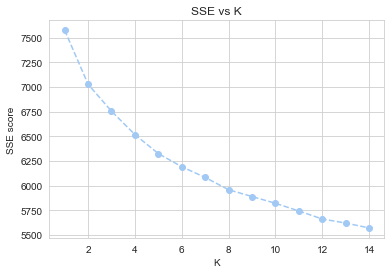

In [28]:
%matplotlib inline
elbow_method(Inp_data_scaled)

In [29]:
model = KMeans(n_clusters=6)
model.fit(Inp_data_scaled)
kmeans_labels = model.labels_

In [30]:
df_clustered_kmeans = Inp_data.assign(Cluster=kmeans_labels)
grouped_kmeans = df_clustered_kmeans.groupby(['Cluster']).mean().round(1)
grouped_kmeans

,Duration_in_months,Credit_amount,Inst_to_Income,Time_at_curr_res,Age_in_years,Existing_credits_count,No_of_dependents,Target
Cluster,,,,,,,,
0,18.8,2871.3,2.6,3.3,28.5,1.3,1.0,0.4
1,19.7,2774.8,3.0,2.7,35.8,1.8,1.1,0.2
2,20.8,2599.8,3.1,2.4,31.9,1.1,1.1,0.4
3,15.1,2177.3,2.9,2.6,36.6,1.4,1.3,0.3
4,27.7,5087.1,3.1,3.6,43.4,1.4,1.3,0.4
5,22.7,3933.1,3.0,2.8,36.9,1.5,1.2,0.2


### <center>Model Development

##### <center> Random Forest

<div>
   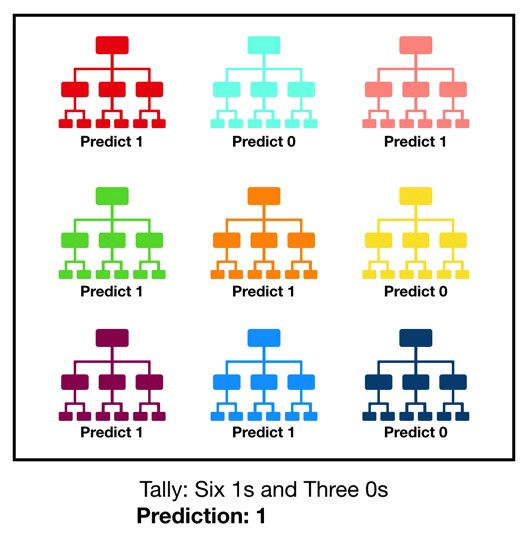
</div>

## <center> XGBoost Model

<div>
   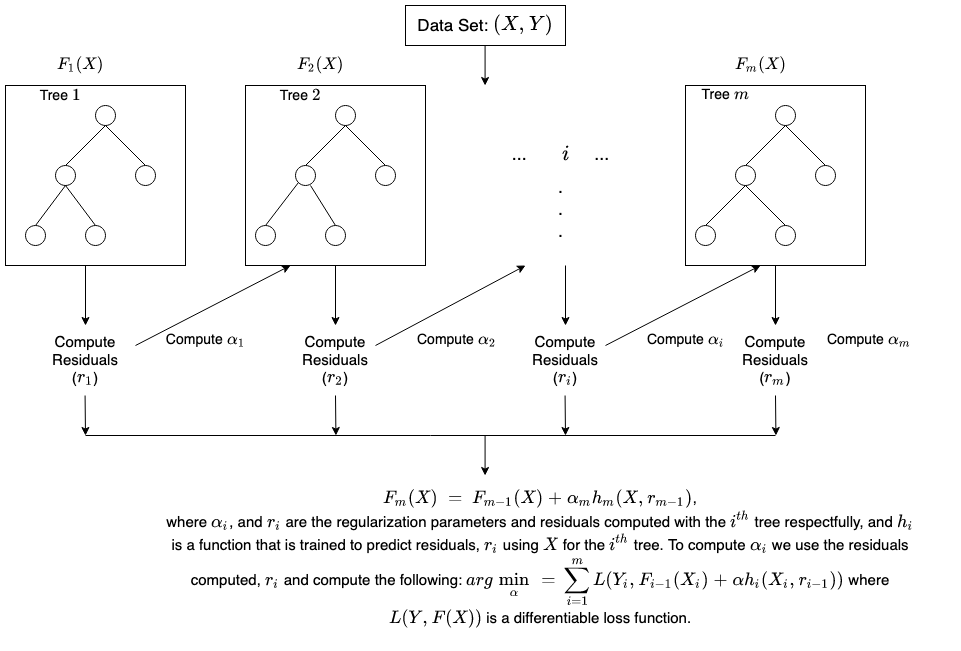
</div>

XGBoost has hyperparameters that need to be tuned.Parameters such as:
- n_estimators
- max_depth
- subsample
- learning_rate
- gamma
- reg_alpha
- reg_gamma

### <center> Model Evaluation Metrics for Classification Algos

##### <center> Precision, Recall and Accuracy

<div>
   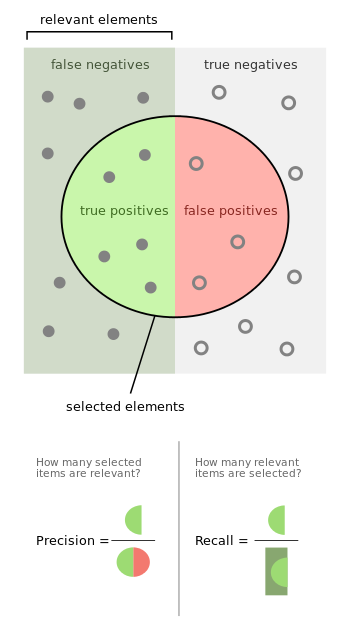
</div>

#### <center>  Confusion Matrix

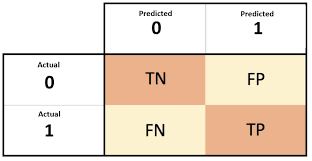


##### <center> ROC Curve: Receiver Operating Characteristic

<div>
   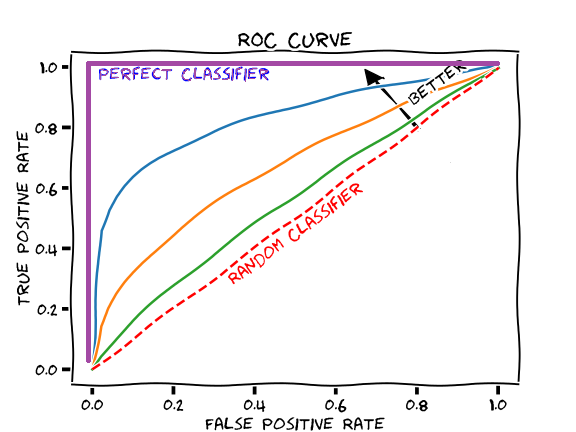
</div>

In [31]:
#############Hold out sample####################

X = Inp_data_scaled.loc[:,Inp_data_scaled.columns != 'Target']
Y = Inp_data_scaled.loc[:,'Target']

## Creating a validation dataset (Holdout sample####)
seed = 9
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [32]:
########## Selecting XGBoost Model and Tuning#######
model = XGBClassifier() 
n_estimators = [100,200,500,1000] 
learning_rate= [0.0001, 0.01, 0.1]
param_grid = dict(n_estimators=n_estimators, learning_rate= learning_rate) 
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7) 
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)
  
# Summarizing results###
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 
means = grid_result.cv_results_['mean_test_score'] 
stds = grid_result.cv_results_['std_test_score'] 
params = grid_result.cv_results_['params'] 
for mean, stdev, param in zip(means, stds, params): 
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.5s


Best: 0.783169 using {'learning_rate': 0.1, 'n_estimators': 100}
0.712886 (0.044397) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.714927 (0.045402) with: {'learning_rate': 0.0001, 'n_estimators': 200}
0.718531 (0.049043) with: {'learning_rate': 0.0001, 'n_estimators': 500}
0.725493 (0.055251) with: {'learning_rate': 0.0001, 'n_estimators': 1000}
0.747771 (0.075489) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.766667 (0.070326) with: {'learning_rate': 0.01, 'n_estimators': 200}
0.776713 (0.061189) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.779813 (0.058370) with: {'learning_rate': 0.01, 'n_estimators': 1000}
0.783169 (0.063541) with: {'learning_rate': 0.1, 'n_estimators': 100}
0.778954 (0.058726) with: {'learning_rate': 0.1, 'n_estimators': 200}
0.776569 (0.056906) with: {'learning_rate': 0.1, 'n_estimators': 500}
0.774439 (0.053146) with: {'learning_rate': 0.1, 'n_estimators': 1000}


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   44.9s finished


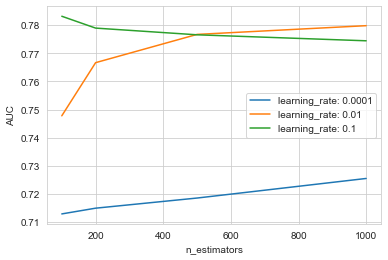

In [33]:
# Plotting results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
    plt.legend()
    plt.xlabel('n_estimators')
    plt.ylabel('AUC')

In [34]:
model = XGBClassifier() 
n_estimators = [100] 
learning_rate= [0.1]
max_depth = range(1, 10, 2)
gamma= [i/10.0 for i in range(0,5)]

param_grid = dict(gamma=gamma,n_estimators=n_estimators, learning_rate= learning_rate,max_depth=max_depth) 
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7) 
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:   11.8s


Best: 0.781266 using {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
0.754333 (0.063486) with: {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}
0.774298 (0.071237) with: {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.776839 (0.058465) with: {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
0.777075 (0.059447) with: {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
0.770470 (0.060906) with: {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100}
0.754333 (0.063486) with: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}
0.775219 (0.069925) with: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.781266 (0.058112) with: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
0.779975 (0.060723) with: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
0.778

[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   14.3s finished


In [35]:
model = XGBClassifier() 
n_estimators = [100] 
learning_rate= [0.1]
max_depth = [5]
gamma= [0.1]
subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
colsample_bytree = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(subsample=subsample,colsample_bytree=colsample_bytree,gamma=gamma,n_estimators=n_estimators, learning_rate= learning_rate,max_depth=max_depth) 
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7) 
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 795 out of 810 | elapsed:   27.6s remaining:    0.4s


Best: 0.798571 using {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
0.769365 (0.071793) with: {'colsample_bytree': 0.1, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.1}
0.762510 (0.059737) with: {'colsample_bytree': 0.1, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.2}
0.770191 (0.065089) with: {'colsample_bytree': 0.1, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.3}
0.770799 (0.065030) with: {'colsample_bytree': 0.1, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.4}
0.780062 (0.060736) with: {'colsample_bytree': 0.1, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5}
0.780830 (0.058111) with: {'colsample_bytree': 0.1, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.6}
0.78

[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:   28.3s finished


In [36]:
######Finalizing Model and Validating on test Data
    
Best_model=  XGBClassifier(learning_rate=0.1,
                           n_estimators=100,
                           max_depth=5,
                           min_child_weight=1,
                           gamma=.1,
                           objective='binary:logistic',
                           colsample_bytree=0.1,
                           subsample=0.8,
                           reg_alpha=0.01
                           )

Best_model.fit(X_train, y_train, eval_metric='auc', verbose=True)
y_pro=Best_model.predict_proba(X_test)[:,1]

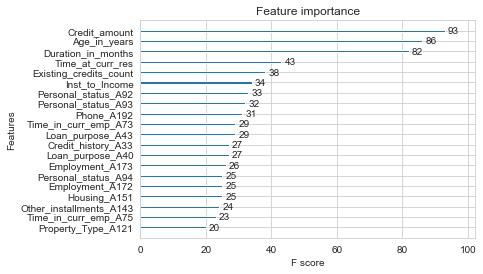

In [37]:
from xgboost import plot_importance
%matplotlib inline
plot_importance(Best_model, max_num_features=20)

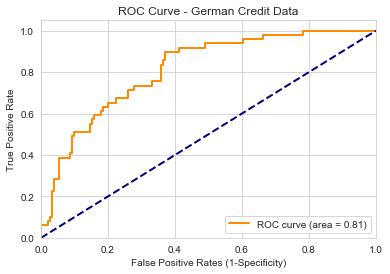

In [38]:
## Plot ROC curve#######
fpr2, tpr2, _ = roc_curve(y_test,
                          y_pro,
                          pos_label = 1)
auc_rf = auc(fpr2, tpr2)

fpr, tpr, thresholds = roc_curve(y_test,y_pro, pos_label = 1)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rates (1-Specificity)')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - German Credit Data')
plt.legend(loc="lower right")
plt.show()

In [39]:
predict_mine = np.where(y_pro > 0.3, 1, 0)
from sklearn.metrics import confusion_matrix
report = classification_report(y_test, predict_mine)
print(report)

              precision    recall  f1-score   support

         0.0       0.89      0.70      0.78       151
         1.0       0.44      0.73      0.55        49

    accuracy                           0.70       200
   macro avg       0.66      0.72      0.67       200
weighted avg       0.78      0.70      0.72       200



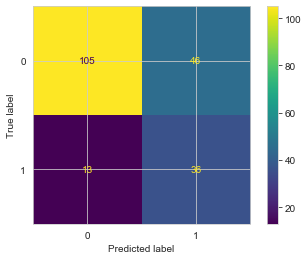

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix(y_test, predict_mine)).plot()

### <center> Model Improvement Exercises 

- Try random search and bayesian search for parameter tuning
- Try multiple encoding methods
- Perform Feature Selection & test other algos
- Derived features for model improvement